# Class 06
## ML Models: Support Vector Machines + Overfitting

We're going back to machine learning models again! This time we are going to look at another type of machine learning algorithm that will give us the opportunity to adjust *hyperparameters*: inputs to the machine learning model that tell the model how to behave. Tuning the hyperparameters is something of an art- we'll talk about Occam's Razor again and how to balance model performance with model complexity. But we'll start with the Support Vector Machine (SVM) classifier and go from there.

### SVM Classifier

We'll use the same set of data that we used in Class 04: the classifier data describing the self-driving car road conditions. We'll load in the data and plot it to make sure we know what we are working with.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

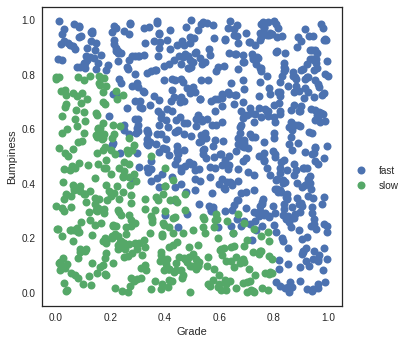

In [2]:
sns.set_style("white")

#Note the new use of the dtype option here. We can directly tell pandas to use the Speed column as a category in one step.
speeddf = pd.read_csv("../Class04/Class04_speed_data.csv",dtype={'Speed':'category'})

#We'll use a different tool to plot the data now that we know how to group the data by a category. This will help us make better combined plots later on.
groups = speeddf.groupby('Speed')

# Plot
trainfig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
# The next step is to cycle through the groups (based on our categories) and plot each one on the same axis.
for name, group in groups:
    ax.plot(group['Grade'], group['Bumpiness'], marker='o', linestyle='', ms=8, label=name)
    ax.set_aspect(1)
ax.legend(bbox_to_anchor=(1,0.5))
ax.set_xlabel('Grade')
ax.set_ylabel('Bumpiness')

The goal, as before, it to build a model to describe the decision boundary between the "fast" and "slow" categories in our label column. We are going to skip the background information on the SVM for now, but you can [read about how it works on Wikipedia](https://en.wikipedia.org/wiki/Support_vector_machine). You can also read about the SVC (support vector classifier)  [on the Scikit Learn pages](http://scikit-learn.org/stable/modules/svm.html).

We run through the same set of steps that we've used before to get ready to teach the model. We are going to start with the simplest SVM: the linear classifier. This will give us a linear decision boundary.

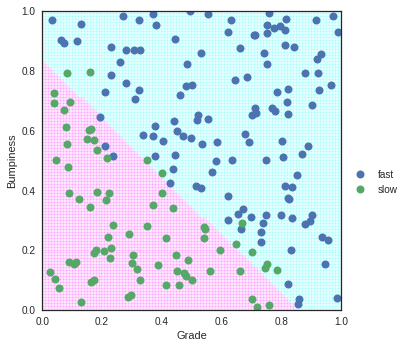

In [3]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

# Split the data into training and testing sets and prepare the features and labels
train, test = train_test_split(speeddf, test_size=0.2, random_state=23)
features_train = train[['Grade','Bumpiness']].values
labels_train = train['Speed'].values
features_test = test[['Grade','Bumpiness']].values
labels_test = test['Speed'].values

# Load the model and fit the data
svcmodel = SVC(kernel='linear')
svcmodel.fit(features_train,labels_train)

# Create our decision boundary mesh
# point in the mesh
x_min = 0.0; x_max = 1.0 # Mesh x size
y_min = 0.0; y_max = 1.0  # Mesh y size
h = .01  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max+h, h), np.arange(y_min, y_max+h, h))

# Prepare the boundary 
Zpred = pd.Series(svcmodel.predict(np.c_[xx.ravel(), yy.ravel()]), dtype='category').cat.codes.values
Z = Zpred.reshape(xx.shape)

# First plot our points
testfig1, ax = plt.subplots()

plt.pcolormesh(xx, yy, Z, cmap= plt.cm.cool, alpha=0.1,axes=ax)
ax.set_aspect(1)

# Plot test points
groups = test.groupby('Speed')
# The next step is to cycle through the groups (based on our categories) and plot each one on the same axis.
for name, group in groups:
    ax.plot(group['Grade'], group['Bumpiness'], marker='o', linestyle='', ms=8, label=name)
ax.legend(bbox_to_anchor=(1,0.5))
ax.set_xlabel('Grade')
ax.set_ylabel('Bumpiness')

[[ 66  10]
 [  2 122]]


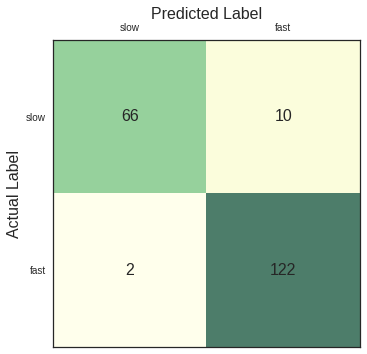

In [4]:
# Let's look at the metrics for this fit:
from sklearn.metrics import confusion_matrix
class_labels = ["slow", "fast"]
y_pred = svcmodel.predict(features_test)
cnf_matrix = confusion_matrix(labels_test, y_pred,labels=class_labels)
print(cnf_matrix)

def show_confusion_matrix(cnf_matrix, class_labels, ax=None):
    
    if not ax:
        plt.matshow(cnf_matrix,cmap=plt.cm.YlGn,alpha=0.7)
        ax = plt.gca()
    else:
        ax.matshow(cnf_matrix,cmap=plt.cm.YlGn,alpha=0.7)
    ax.set_xlabel('Predicted Label', fontsize=16)
    ax.set_xticks(range(0,len(class_labels)))
    ax.set_xticklabels(class_labels)
    ax.set_ylabel('Actual Label', fontsize=16, rotation=90)
    ax.set_yticks(range(0,len(class_labels)))
    ax.set_yticklabels(class_labels)
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()

    for row in range(len(cnf_matrix)):
        for col in range(len(cnf_matrix[row])):
            ax.text(col, row, cnf_matrix[row][col], va='center', ha='center', fontsize=16)
        
show_confusion_matrix(cnf_matrix,class_labels)

In [5]:
import sklearn.metrics as metrics

recall_score = metrics.recall_score(labels_test, y_pred,labels=class_labels,average=None)
prec_score = metrics.precision_score(labels_test, y_pred,labels=class_labels,average=None)
f1_score = metrics.f1_score(labels_test, y_pred,labels=class_labels,average=None)

acc_score = metrics.accuracy_score(labels_test, y_pred)
matt_score = metrics.matthews_corrcoef(labels_test, y_pred)

print("Class-dependent Metrics")
print("Sensitivity/Recall Score: {}".format(recall_score))

print("Precision Score: {}".format(prec_score))
print("F1 Score: {}".format(f1_score))

print("\nClass-independent Metrics")
print("Accuracy Score: {}".format(acc_score))
print("Matthews Correlation Coefficient (MCC): {}".format(matt_score))


Class-dependent Metrics
Sensitivity/Recall Score: [ 0.86842105  0.98387097]
Precision Score: [ 0.97058824  0.92424242]
F1 Score: [ 0.91666667  0.953125  ]

Class-independent Metrics
Accuracy Score: 0.94
Matthews Correlation Coefficient (MCC): 0.8733023707219416


At this point I want to go back to the last set of classifiers we looked at with this exact same dataset: the Perceptron and the Naïve Bayes. For comparison, here were the metrics for those two classifiers:

#### Perceptron:
***
Class-dependent Metrics
* Sensitivity/Recall Score: [ 1.          0.83870968]
* Precision Score: [ 0.79166667  1.        ]
* F1 Score: [ 0.88372093  0.9122807 ]

Class-independent Metrics
* Accuracy Score: 0.9
* Matthews Correlation Coefficient (MCC): 0.8148487556741162

##### Naïve Bayes:
***
Class-dependent Metrics
* Sensitivity/Recall Score: [ 0.80263158  0.98387097]
* Precision Score: [ 0.96825397  0.89051095]
* F1 Score: [ 0.87769784  0.9348659 ]

Class-independent Metrics
* Accuracy Score: 0.915
* Matthews Correlation Coefficient (MCC): 0.8218398836470786


We see that the SVC model did better than both of these other models in all of the metrics! Not bad considering it is a linear fit. Now we can look a little more closely and how the SVC model works. It picks a few data points from the training set to use as "support" points and then plots the decision boundary as a line between those points. So, in essence, it is a model that has the number of support points as the number of model parameters. That is important because it tells us about the model complexity. Let's look at our linear model and show which points the model is using as its support points.

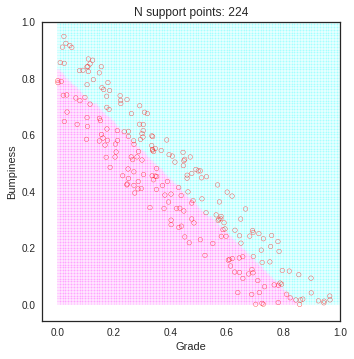

In [6]:
support_points = features_train[svcmodel.support_]

#We plot the decision boundary and the support points
figsvc1 ,ax = plt.subplots()
ax.set_title("N support points: {}".format(len(support_points)))
ax.pcolormesh(xx, yy, Z, cmap= plt.cm.cool, alpha=0.1)
ax.set_aspect(1)

ax.set_xlabel('Grade')
ax.set_ylabel('Bumpiness')
ax.scatter(x=support_points[:,0],y=support_points[:,1],s=20, facecolors='none', edgecolors='r')

We see that there are actually a large number of support points in this model! So, even though it ends up being a linear decision boundary, it has quite a high complexity. Does the improvement in performance justify this increase in complexity? Perhaps...

Before we go on, we need to note that the SVC model only works well for small-ish datasets (less than 100,000 points). Beyond that, it will slow down considerably. It may be worth your time to try using this model on larger datasets, but I wanted to warn you about that.

### First Hyperparameter: C

Let's dive into the model hyperparameters! The only hyperparameter for the model at this point is the `C` parameter. The SVC model is always looking for a perfect boundary: it wants to perfectly classify every point in the training set. So, what do we do about points that just aren't going to be classified perfectly? We apply a "penalty" for those points and try and lower the penalty as much as we can to do as best as we can. The size of the penalty we apply is related to the `C` parameter. Let's try two extremes with our linear decision boundary to see what they do (it defaults to the value of `C=1.0` if we don't tell the model to use a different value). 

We're going to use a set of sub-plots so we can put both the confusion matrix and the support vector points on the same line.

Matthews Correlation Coefficient (MCC): 0.7768273338142284


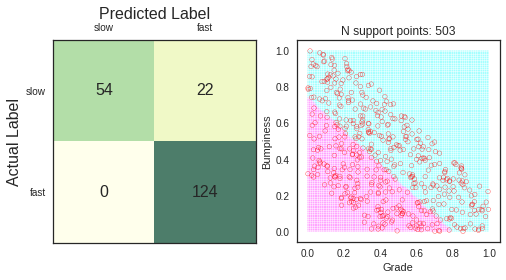

In [7]:
# Start with a value of C=0.05
svcmodel2 = SVC(kernel='linear',C=.05)
svcmodel2.fit(features_train,labels_train)
Z = pd.Series(svcmodel2.predict(np.c_[xx.ravel(), yy.ravel()]), dtype='category').cat.codes.values.reshape(xx.shape)
support_points = features_train[svcmodel2.support_]

fig = plt.figure()
ax1 = fig.add_subplot(121)

y_pred = svcmodel2.predict(features_test)
cnf_matrix = confusion_matrix(labels_test, y_pred,labels=class_labels)
show_confusion_matrix(cnf_matrix,class_labels,ax=ax1)
matt_score = metrics.matthews_corrcoef(labels_test, y_pred)
print("Matthews Correlation Coefficient (MCC): {}".format(matt_score))

ax2 = fig.add_subplot(122)
# First plot our points
ax2.pcolormesh(xx, yy, Z, cmap= plt.cm.cool, alpha=0.1)
ax2.set_title("N support points: {}".format(len(support_points)))
ax2.set_aspect(1)
ax2.set_xlabel('Grade')
ax2.set_ylabel('Bumpiness')
# Circle the support points

ax2.scatter(x=support_points[:,0],y=support_points[:,1],s=20, facecolors='none', edgecolors='r')

Note that the number of support points has dramatically increased but the overall quality of the fit (as measured by the MCC) has decreased! We've added complexity and not improved our performance at all. This is called **overfitting** and we'll see more examples of it later.

So, let's go to the other extreme and make `C` large.

Matthews Correlation Coefficient (MCC): 0.8725152490099218


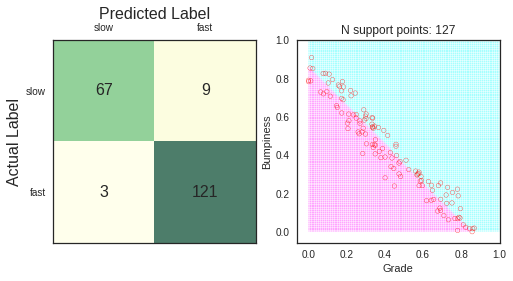

In [8]:
svcmodel3 = SVC(kernel='linear',C=1000)
svcmodel3.fit(features_train,labels_train)
# Prepare the boundary 
Z = pd.Series(svcmodel3.predict(np.c_[xx.ravel(), yy.ravel()]), dtype='category').cat.codes.values.reshape(xx.shape)
support_points = features_train[svcmodel3.support_]

fig2 = plt.figure()
ax1 = fig2.add_subplot(121)

y_pred = svcmodel3.predict(features_test)
cnf_matrix = confusion_matrix(labels_test, y_pred,labels=class_labels)
show_confusion_matrix(cnf_matrix,class_labels,ax=ax1)
matt_score = metrics.matthews_corrcoef(labels_test, y_pred)
print("Matthews Correlation Coefficient (MCC): {}".format(matt_score))

ax2 = fig2.add_subplot(122)
# First plot our points
ax2.pcolormesh(xx, yy, Z, cmap= plt.cm.cool, alpha=0.1)
ax2.set_aspect(1)
ax2.set_title("N support points: {}".format(len(support_points)))
ax2.set_xlabel('Grade')
ax2.set_ylabel('Bumpiness')
# Circle the support points

ax2.scatter(x=support_points[:,0],y=support_points[:,1],s=20, facecolors='none', edgecolors='r')

Now we've reduced the number of parameters without reducing the MCC very much at all. At this point it doesn't matter how much bigger we make `C`, the SVC algorithm can't do any better.

### The RBF Kernel

Now that we've looked at the linear SVC, we can extend this model in a very simple way: instead of demanding that the decision boundary be a straight line, we let the boundary wiggle between points. This gives us another hyperparameter to work with: $\gamma$: this parameter tells the SVC how close it should try and get to any given point. The best thing to do is to try out a couple of combinations to see how they perform.

Matthews Correlation Coefficient (MCC): 0.8733023707219416


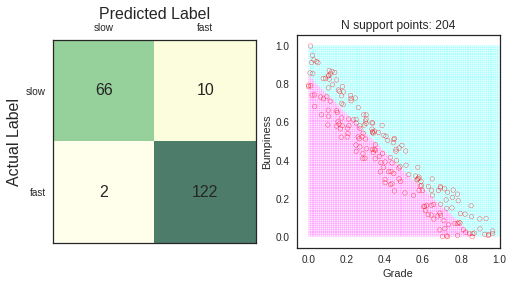

In [9]:
svcmodel4 = SVC(kernel='rbf',C=1, gamma=1)
svcmodel4.fit(features_train,labels_train)
y_pred = svcmodel4.predict(features_test)
# Prepare the boundary 
Z = pd.Series(svcmodel4.predict(np.c_[xx.ravel(), yy.ravel()]), dtype='category').cat.codes.values.reshape(xx.shape)
support_points = features_train[svcmodel4.support_]

fig4 = plt.figure()
ax1 = fig4.add_subplot(121)
cnf_matrix = confusion_matrix(labels_test, y_pred,labels=class_labels)
show_confusion_matrix(cnf_matrix,class_labels,ax=ax1)
matt_score = metrics.matthews_corrcoef(labels_test, y_pred)
print("Matthews Correlation Coefficient (MCC): {}".format(matt_score))

ax2 = fig4.add_subplot(122)
# First plot our points
ax2.pcolormesh(xx, yy, Z, cmap= plt.cm.cool, alpha=0.1)
ax2.set_title("N support points: {}".format(len(support_points)))
ax2.set_aspect(1)
ax2.set_xlabel('Grade')
ax2.set_ylabel('Bumpiness')
# Circle the support points

ax2.scatter(x=support_points[:,0],y=support_points[:,1],s=20, facecolors='none', edgecolors='r')

This looks a lot like the linear boundary! We'll try changing the values to see what they do.

Matthews Correlation Coefficient (MCC): 0.8526304166916007


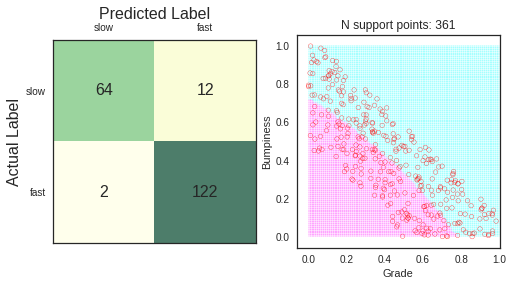

In [10]:
svcmodel5 = SVC(kernel='rbf',C=0.1, gamma=1)
svcmodel5.fit(features_train,labels_train)
y_pred = svcmodel5.predict(features_test)
# Prepare the boundary 
Z = pd.Series(svcmodel5.predict(np.c_[xx.ravel(), yy.ravel()]), dtype='category').cat.codes.values.reshape(xx.shape)
support_points = features_train[svcmodel5.support_]

fig5 = plt.figure()
ax1 = fig5.add_subplot(121)
cnf_matrix = confusion_matrix(labels_test, y_pred,labels=class_labels)
show_confusion_matrix(cnf_matrix,class_labels,ax=ax1)
matt_score = metrics.matthews_corrcoef(labels_test, y_pred)
print("Matthews Correlation Coefficient (MCC): {}".format(matt_score))

ax2 = fig5.add_subplot(122)
# First plot our points
ax2.pcolormesh(xx, yy, Z, cmap= plt.cm.cool, alpha=0.1)
ax2.set_title("N support points: {}".format(len(support_points)))
ax2.set_aspect(1)
ax2.set_xlabel('Grade')
ax2.set_ylabel('Bumpiness')
# Circle the support points

ax2.scatter(x=support_points[:,0],y=support_points[:,1],s=20, facecolors='none', edgecolors='r')

Reducing the penalty looks like it added a bit of curvature, but it increased the number of support points and lowered the MCC. Let's try the other way.

#### Programming Aside Note:

Take a quick look at the previous two blocks of code: they were identical except for a couple of parameters at the top. This is a good indication that we should write our own function to simplify running more examples. Python makes that really easy: we add one line at the top, change the parameter inputs to the model, and indent the rest of the code.

Matthews Correlation Coefficient (MCC): 0.8830473335328681


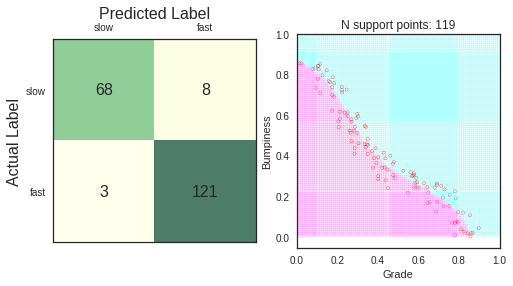

In [11]:
def testsvcmodel(inputC,inputgamma):
    svcmodelf = SVC(kernel='rbf',C=inputC, gamma=inputgamma)
    svcmodelf.fit(features_train,labels_train)
    y_pred = svcmodelf.predict(features_test)
    # Prepare the boundary 
    Z = pd.Series(svcmodelf.predict(np.c_[xx.ravel(), yy.ravel()]), dtype='category').cat.codes.values.reshape(xx.shape)
    support_points = features_train[svcmodelf.support_]

    figf = plt.figure()
    ax1 = figf.add_subplot(121)
    cnf_matrix = confusion_matrix(labels_test, y_pred,labels=class_labels)
    show_confusion_matrix(cnf_matrix,class_labels,ax=ax1)
    matt_score = metrics.matthews_corrcoef(labels_test, y_pred)
    print("Matthews Correlation Coefficient (MCC): {}".format(matt_score))

    ax2 = figf.add_subplot(122)
    # First plot our points
    ax2.pcolormesh(xx, yy, Z, cmap= plt.cm.cool, alpha=0.1)
    ax2.set_title("N support points: {}".format(len(support_points)))
    ax2.set_aspect(1)
    ax2.set_xlabel('Grade')
    ax2.set_ylabel('Bumpiness')
    # Circle the support points

    ax2.scatter(x=support_points[:,0],y=support_points[:,1],s=10, facecolors='none', edgecolors='r')

# Now we just need to call the function!
testsvcmodel(inputC=100,inputgamma=1)

So we've reduced the number of support points and *increased* the performance of the model! The boundary is no longer a straight line, but it seems to do better than the straight line did. This is an example of reducing complexity **and** improving performance. That's the direction we want to go! Let's try the other hyperparameter: $\gamma$.


Matthews Correlation Coefficient (MCC): 0.9151103565365025


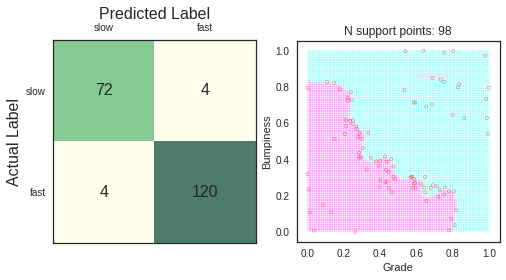

In [12]:
testsvcmodel(inputC=100,inputgamma=50)

So we've improved performance again! But this time, look at the support points and the decision boundary: they are both a mess! This is a complicated model that is trying hard to fit a very particular shape that doesn't look like it is really our dataset. In other words, it looks like it is trying to fit to the noise in the data as opposed to fitting the underlying model. This is what we mean by **overfitting** and it is going the wrong way! This type of model will most likely perform poorly when we head out to try it in the "real world".

We'll try the other combinations now.

Matthews Correlation Coefficient (MCC): 0.893548021473575


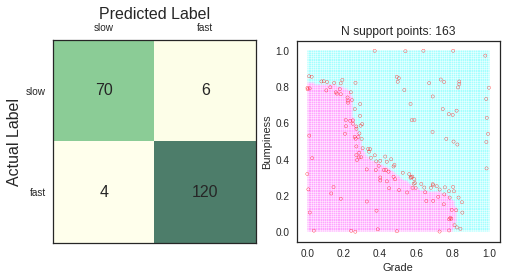

In [13]:
testsvcmodel(inputC=1,inputgamma=50)

Matthews Correlation Coefficient (MCC): 0.883047333532868


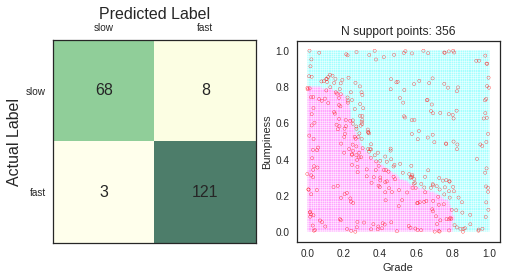

In [14]:
testsvcmodel(inputC=0.1,inputgamma=50)

Matthews Correlation Coefficient (MCC): 0.8620192068216507


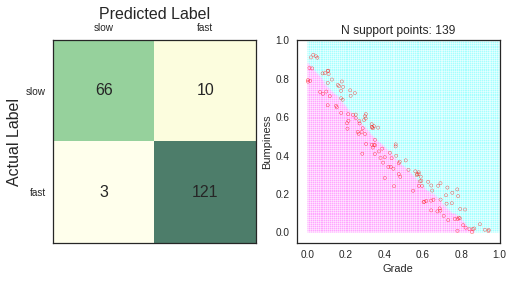

In [15]:
testsvcmodel(inputC=100,inputgamma=0.1)

Matthews Correlation Coefficient (MCC): 0.3893166361692745


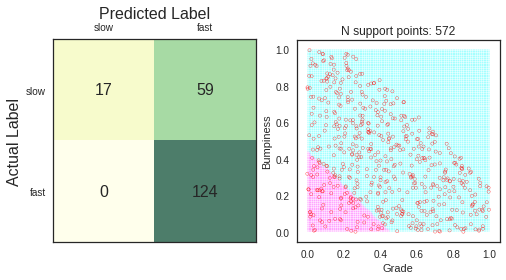

In [16]:
testsvcmodel(inputC=0.1,inputgamma=0.1)

So, looking at all of these together, it looks like our best performance with the simplest model was where we had `C=100` and $\gamma$`=1`. If we want to try to do even better, we could tune the paramters even further by exploring around this point to see if we can do a little better. Later in the course we'll take a look at tools that will simplify doing that optimization for us.


## Support Vector Regressions

We can use this same type of tool to make predictions for continuous data as well. We will return to the fake data we used in Class 02 to see how to apply the SVM regression.

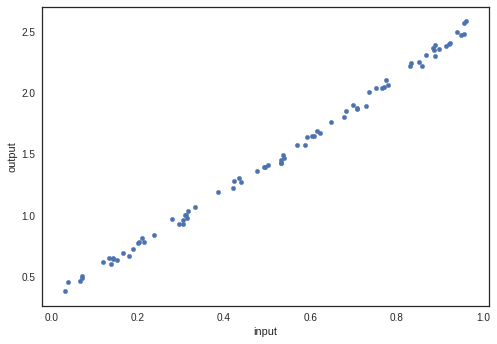

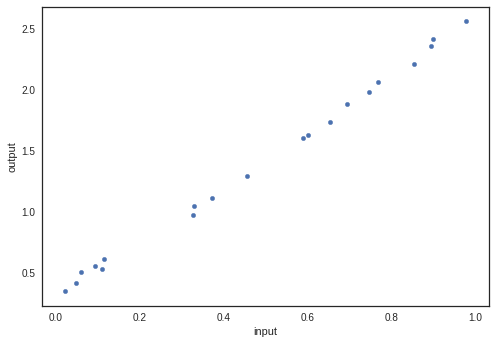

In [17]:
fakedata2 = pd.read_csv('../Class02/Class02_fakedata2.csv')
faketrain2, faketest2 = train_test_split(fakedata2, test_size=0.2, random_state=23)
faketrain2.plot.scatter(x='input',y='output')
faketest2.plot.scatter(x='input',y='output')

As a reminder, let's review the linear regression along with its graph.

RMS Error: 0.041


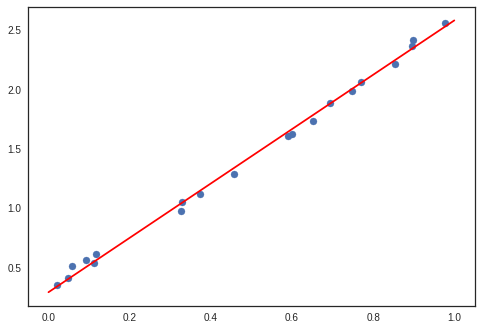

In [18]:
from sklearn.linear_model import LinearRegression
regr = LinearRegression()
features = faketrain2[['input']].values
labels = faketrain2['output'].values
regr.fit(features,labels)

testinputs = faketest2[['input']].values
predictions = regr.predict(testinputs)
actuals = faketest2['output'].values
print("RMS Error: {0:.3f}".format( np.sqrt(np.mean((predictions - actuals) ** 2))))

# Prepare the model line
X_plot =np.linspace(0, 1, 1000)
Y_pred = regr.predict(X_plot[:,None])

trainfig, ax = plt.subplots()

# First plot our points
ax.scatter(x=testinputs, y=actuals)

ax.plot(X_plot,Y_pred,c='r')

Ok, we now try the support vector regression model.

RMS Error: 0.072


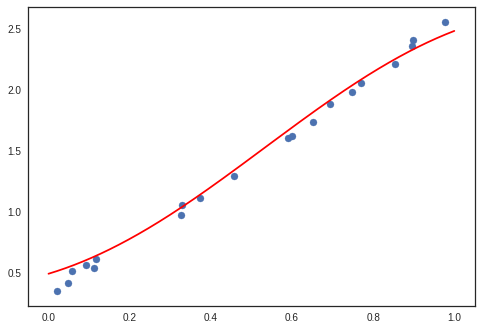

In [19]:
from sklearn.svm import SVR
svrmodel = SVR(C=1.0,gamma=1.0)

svrmodel.fit(features,labels)

svrpredictions = svrmodel.predict(testinputs)

print("RMS Error: {0:.3f}".format( np.sqrt(np.mean((svrpredictions - actuals) ** 2))))

# Prepare the model line
Y_pred = svrmodel.predict(X_plot[:,None])

trainfig, ax = plt.subplots()
# First plot our points
ax.scatter(x=testinputs, y=actuals)
ax.plot(X_plot,Y_pred,c='r')

That performance was worse than the linear model (an RMS error of 0.0 means a perfect fit). Let's try adjusting the hyperparameters. We'll make a function to make it easy to repeat this.

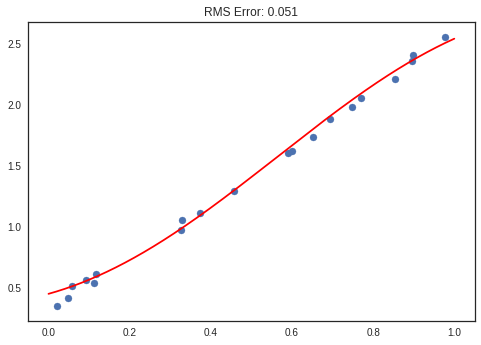

In [20]:
def svrtest(inputC, inputgamma):
    svrmodel = SVR(C=inputC,gamma=inputgamma)
    svrmodel.fit(features,labels)
    svrpredictions = svrmodel.predict(testinputs)
    
    # Prepare the model line
    Y_pred = svrmodel.predict(X_plot[:,None])
    trainfig, ax = plt.subplots()
    ax.set_title("RMS Error: {0:.3f}".format( np.sqrt(np.mean((svrpredictions - actuals) ** 2))))
    # First plot our points
    ax.scatter(x=testinputs, y=actuals)
    ax.plot(X_plot,Y_pred,c='r')
svrtest(100,1)

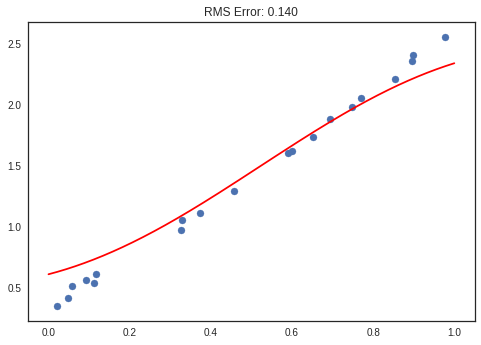

In [21]:
svrtest(0.1,1)

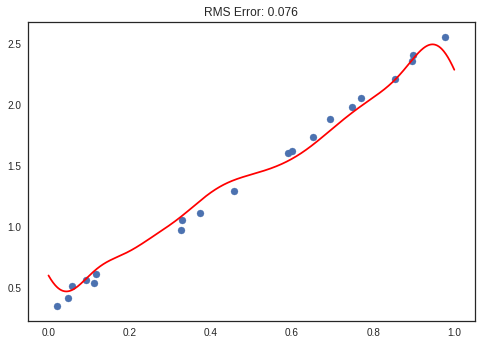

In [22]:
svrtest(1,100)

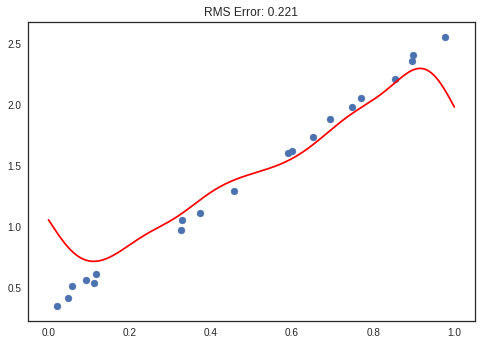

In [23]:
svrtest(0.1,100)

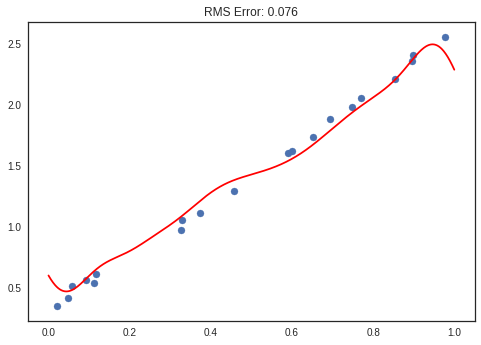

In [24]:
svrtest(100,100)

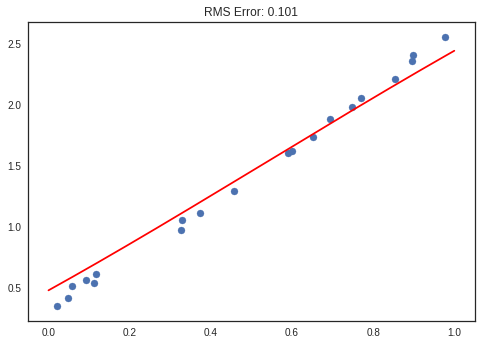

In [25]:
svrtest(1,0.1)

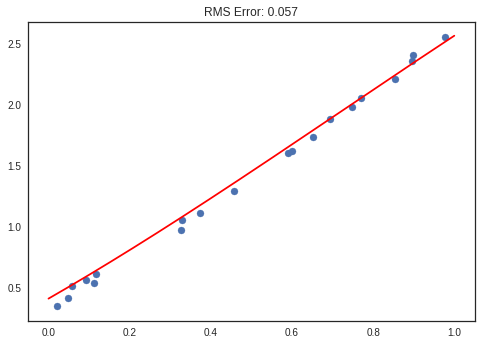

In [26]:
svrtest(100,0.1)

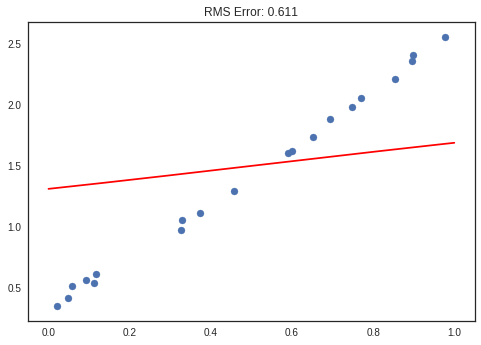

In [27]:
svrtest(0.1,0.1)

It looks like the best we can do with the SVR is actually *worse* than the linear regression! This is another example where model complexity doesn't necessarily improve performance. Occam's razor says we should go with the simplest model and, in this case, it is the linear regression.

## In-class Activity

We used a multi-feature dataset in Class 02 to try out the regression. Use the SVM regression on that dataset to see if you can do any better in predicting the output.

## Assignment

Implement either the SVM classifier or regression on your own data. You can do multi-class predictions with the classifier so it should be able to handle pretty much any dataset. Record the time it takes for the model to fit on your data and compare that to the Perceptron and Naive Bayes models we did last week.